# Proton Spin Up

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy import optimize
from scipy.optimize import curve_fit

## Polarization vs Time

<Axes: title={'center': 'Polarization Over Time'}, xlabel='Datetime', ylabel='Polarization'>

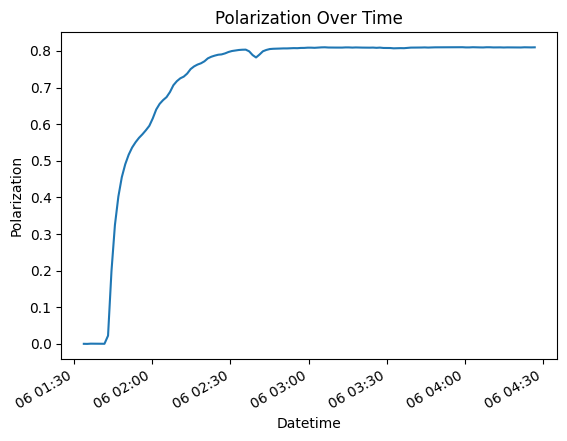

In [2]:

with open("2022-11-05_23-29-51__2022-11-06_11-20-39.txt","r") as eventfile:
    df = pd.read_json(eventfile, lines=True)
df['stop_time'] = pd.to_datetime(df['stop_time'])
df.set_index('stop_time', inplace=True)

df['pol'].plot(title='Polarization Over Time',
                      xlabel='Datetime',
                      ylabel='Polarization')


## Interactive Plot, Drag Slider to Select Result Curve

In [3]:
def plot_pol_array(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']  # Get array from selected row
    plt.plot(signal_array, linewidth=2)
    plt.title(f"Result Signal {index} (Polarization: {df.iloc[index]['pol']:.2f})")
    plt.grid(True, alpha=0.3)
    plt.show()


# Create interactive widget
interact(plot_pol_array,
         index=IntSlider(min=0, max=len(df)-1, step=1, value=9,
                         description='Row Index:'))


interactive(children=(IntSlider(value=9, description='Row Index:', max=131), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array(index)>

In [ ]:
# Define Gaussian(s)
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def three_gaussians(x, *params):
    return sum(gaussian(x, *params[i:i+3]) for i in range(0, 9, 3))

# Store fit results
fit_results = []

# Fit and plot individual curve
def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    popt, _ = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)

    # Append results
    fit_results.append({
        'index': index,
        'time': df.index[index],
        'pol': df.iloc[index]['pol'],
        'params': popt
    })

    # Plot original and fit
    plt.plot(x_data, signal_array, label='Original Signal', linewidth=2)
    plt.plot(x_data, three_gaussians(x_data, *popt), '--', color='red', label='Total Fit')

    # Plot Gaussians
    colors = ['blue', 'green', 'purple']
    for i in range(3):
        amp, cen, wid = popt[i*3:i*3+3]
        label = f'Gaussian{i+1}: Amplitude={amp:.4f}, Center={cen:.1f}, Width={np.abs(wid):.1f}'
        g = gaussian(x_data, amp, cen, wid)
        plt.plot(x_data, g, linestyle=':', color=colors[i], label=label)

    plt.title(f"Signal {index} | Polarization: {df.iloc[index]['pol']:.2f}")
    plt.xlabel("Index")
    plt.ylabel("Signal")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Create slider
interact(plot_pol_array_with_fit,
         index=IntSlider(min=0, max=len(df)-1, step=1, value=9, description='Row Index:'))






interactive(children=(IntSlider(value=9, description='Row Index:', max=131), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array_with_fit(index)>

C:\Users\Direc\AppData\Local\Temp\ipykernel_17680\4144999850.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


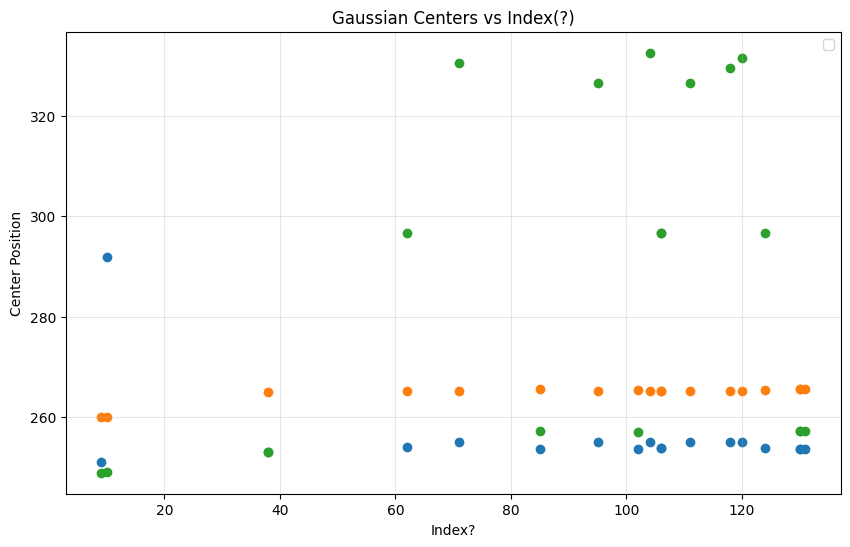

In [6]:
# Convert fit results to DataFrame
fit_df = pd.DataFrame(fit_results)

# How Gaussian center changes with polarization
plt.figure(figsize=(10,6))
gauss_cen1 = [x[1] for x in fit_df['params']]
plt.scatter(fit_df['index'], gauss_cen1)
gauss_cen2 = [x[4] for x in fit_df['params']]
plt.scatter(fit_df['index'], gauss_cen2)
gauss_cen3 = [x[7] for x in fit_df['params']]
plt.scatter(fit_df['index'], gauss_cen3)

plt.xlabel('Index?')
plt.ylabel('Center Position')
plt.title('Gaussian Centers vs Index(?)')
plt.grid(True, alpha = 0.3)
plt.legend()
plt.show()

C:\Users\Direc\AppData\Local\Temp\ipykernel_17680\2873191035.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)


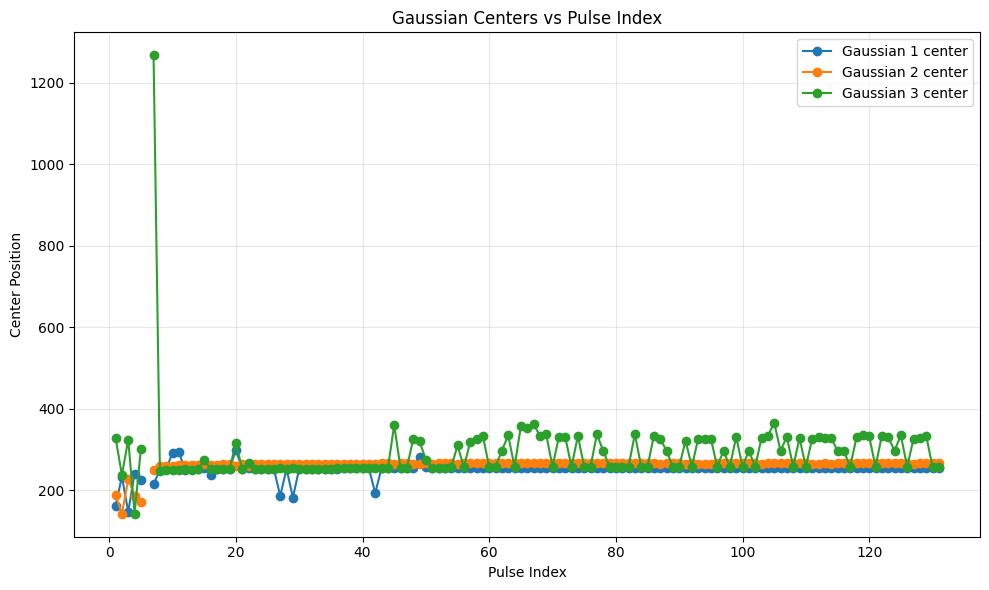

In [7]:
# Re-initialize fit_results in case it was already used
fit_results = []

# Loop over all indexes in df and fit the signal without plotting
for index in range(len(df)):
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    try:
        popt, _ = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)
        fit_results.append({
            'index': index,
            'time': df.index[index],
            'pol': df.iloc[index]['pol'],
            'params': popt
        })
    except RuntimeError:
        # If fit fails, append NaNs to keep indexing consistent
        fit_results.append({
            'index': index,
            'time': df.index[index],
            'pol': df.iloc[index]['pol'],
            'params': [np.nan]*9
        })

# Convert fit results to DataFrame
fit_df = pd.DataFrame(fit_results)

# Plot the center positions of each Gaussian over pulse index
plt.figure(figsize=(10, 6))
for i in range(3):
    centers = fit_df['params'].apply(lambda p: p[i*3+1] if isinstance(p, (list, np.ndarray)) else np.nan)
    plt.plot(fit_df['index'], centers, 'o-', label=f'Gaussian {i+1} center')

plt.xlabel('Pulse Index')
plt.ylabel('Center Position')
plt.title('Gaussian Centers vs Pulse Index')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
